# A first look at data

date: 12/04/2018

Example code for reading and checking data


In [ ]:
import pandas as pd
import dask.dataframe as dd
import glob as glob
import numpy as np
from scipy.stats import kde
import os

filepath='/home/ioana/src/icecube/Noemi/stage/cic_att' 
os.chdir(filepath)
%run data_functions.py
from data_functions import obtain_attenuation

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.colors import LogNorm
plt.rc('font', size=16)
plt.rcParams['figure.figsize'] = (10.0, 10.0)    # resize plots

This is the part that reads data and makes a basic selection

In [2]:
df = pd.DataFrame()
df = pd.read_hdf('/data/IceCube/merged2015.h5', key='data')
df['cos2'] = np.cos(df.zenith)**2
df['I'] = 0
df['s125_error'] = 0.1*df['s125']

df.drop(df.columns.difference(['s125', 's125_error',"cos2", "I","zenith"]), 1, inplace= True)
df= df.loc[df.s125>4]
df= df.loc[df.cos2>0.5]  
df.reset_index(inplace=True)
print('You have selected {} events'.format(df.s125.count()))



You have selected 1075270 events


In [3]:
###attenuation curve
from data_functions import obtain_attenuation
nr_of_bins = 8
intensity = 500
samples = 10
import time
start_time = time.time()
intensities = np.linspace(1.5, 5., 10)
global_res = {}

for i, inte in enumerate(intensities):
    print(i, int(10**inte))
    fit_results, fitted_data = obtain_attenuation(df, nr_of_bins, int(10**inte), samples)
    global_res[inte]= (fit_results, fitted_data)
    #global_results.append(fitted_results)   
    #global_data.append(fitted_data)
    print("--- %s seconds ---" % (time.time() - start_time))



  0%|          | 0/10 [00:00<?, ?it/s]/data/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 10/10 [00:24<00:00,  2.49s/it]

0 31
--- 25.04034662246704 seconds ---


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


1 77
--- 49.59969210624695 seconds ---


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


2 189
--- 74.21984910964966 seconds ---


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


3 464
--- 98.74620270729065 seconds ---


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


4 1136
--- 123.44384384155273 seconds ---


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


5 2782
--- 148.01073741912842 seconds ---


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


6 6812
--- 172.69406008720398 seconds ---


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


7 16681
--- 197.18510246276855 seconds ---


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


8 40842
--- 221.8228166103363 seconds ---


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


9 100000
--- 245.44969964027405 seconds ---


[  0.87224234  -1.77907782  39.75874538]
[ -2.19617564e-01  -4.65137495e+00   3.57735920e+02]
[   0.29789343   -3.36625518  165.01888678]
[  0.76448105  -1.97172523  65.48757668]
[  0.98715176  -1.78014929  14.68679136]
[ 1.1410017  -1.99525453  5.64520747]
[  5.13420927e-02  -3.78935014e+00   2.42124419e+02]
[ 1.05914668 -1.70955197  9.03778619]
[  0.95140678  -1.68673787  24.13343084]
[   0.52443575   -2.61375155  104.49017768]


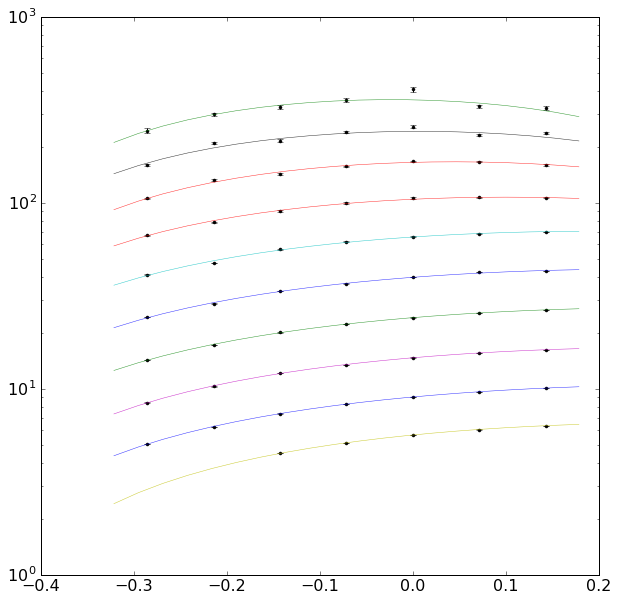

In [7]:
fig, ax =plt.subplots()

cos_ref = np.cos(math.radians(25))**2
cos2 = np.linspace(0.5, 1, 20)-cos_ref
ar = [(0,0,0)]
br = [(0,0,0)]
sr = [(0,0,0)]

all_vals = pd.DataFrame(columns= ["a", "aer1", "aer2", "b", "ber1", "ber2", "s", "ser", "ser2", "I"])
for key in global_res:
    if int(10**key) == 3162:
        continue
    sample = global_res[key][0]
    print(sample['params'])
    params = global_res[key][0]['params']
    error = global_res[key][0]['err']
    groups = global_res[key][1]
    try:
        a_mcmc,  b_mcmc,  s38_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                      zip(*np.percentile(sample, [16, 50, 84],
                                          axis=0)))
    except:
        a_mcmc = (params[0], error[0], error[0])
        b_mcmc = (params[1], error[1], error[1])
        s38_mcmc = (params[2], error[2], error[2])
        
    all_vals = all_vals.append({"a":a_mcmc[0], "aer1":a_mcmc[1], "aer2":a_mcmc[2], "b":b_mcmc[0], "ber1":b_mcmc[1],
                    "ber2":b_mcmc[2],"s":s38_mcmc[0], "ser":s38_mcmc[1], "ser2":s38_mcmc[2],"I":key},
                   ignore_index = True)
    #print("a = %f + %f - %f"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
    #print("b = %f + %f - %f"%(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
    #print("s_ref = %f + %f - %f\n"%(s38_mcmc[0],s38_mcmc[1],s38_mcmc[2]))
    ax.errorbar(groups.cos2.mean()-cos_ref, groups.s125.mean(), yerr= groups.s125.std().tolist(),label = "", fmt=".k")
    #for a, b, f in sample[np.random.randint(len(sample), size=100)]:
    #    ax.plot(cos2, f * (b * cos2**2 + a * cos2 + 1), color="b", alpha=0.03)
    
    ax.plot(cos2, s38_mcmc[0]*(b_mcmc[0] * cos2**2 + a_mcmc[0] * cos2 + 1), lw=0.5, alpha=0.8, label="%s"%int(s38_mcmc[0]))

    
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0])))
#print(labels)
#ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
#plt.legend()
ax.set_yscale("log", nonposy='clip')



[ 1.05259839 -1.55426976  2.99630678]
[ 1.85510581 -1.00737353  2.42500775]
[ 0.97270776 -1.62231666  5.15364308]
[ 1.772715   -1.17892086  4.29458168]
[ 0.8928854  -1.68369517  8.86424652]
[ 1.69057567 -1.34394996  7.60553857]
[  0.81312203  -1.73839897  15.24644916]
[  1.60867932  -1.50247793  13.46915783]
[  0.73340835  -1.78642076  26.22375989]
[  1.52701749  -1.6545211   23.85350841]
[  0.65373502  -1.82775234  45.10456953]
[  1.44558172  -1.80009503  42.24403877]
[  0.57409268  -1.86238433  77.57922266]
[  1.3643636   -1.93921452  74.81349359]
[   0.49447192   -1.89030667  133.43494177]
[   1.28335471   -2.07189362  132.49386332]
[   0.41486334   -1.91150806  229.50542054]
[   1.20254666   -2.19814556  234.64586513]
[  3.35257448e-01  -1.92597618e+00   3.94743982e+02]
[   1.12193108   -2.31798291  415.55771559]


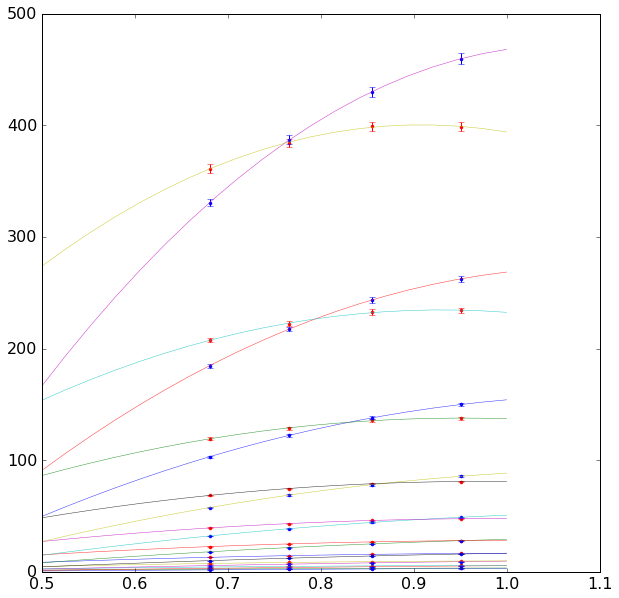

In [74]:
pr_A = [5.998, 6.034, 6.081,6.139]
pr_B = [0.962, 0.948,0.936,0.923]

Fe_A = [6.069, 6.13, 6.202, 6.288]
Fe_B = [0.913, 0.900, 0.888, 0.878]
#mixed = [6.018, 6.062, 6.117,6.182]
#mixed_B = [0.938, 0.929,0.921,0.914]
#Fe_A = [6.018, 6.062, 6.117,6.182]
#Fe_B = [0.938, 0.929,0.921,0.914]

cos = [0.975, 0.925, 0.875,0.825]
energy = np.linspace(15.5, 17.5, 10)
%run data_functions.py
from utils import get_s125
param = []
param2 = []

ener = []
cos2_proxy = np.asarray(cos)**2
for ind, en in enumerate(energy):
    s_pr = 10**( (en-np.asarray(pr_A)-9) /np.asarray(pr_B) )
    s_fe = 10**( (en-np.asarray(Fe_A )-9) /np.asarray(Fe_B))

    plt.errorbar(cos2_proxy, s_pr, yerr= 0.01*s_pr, fmt=".r")
    plt.errorbar(cos2_proxy, s_fe, yerr= 0.01*s_fe, fmt=".b")
    params_pr, cov2 = sp.optimize.curve_fit(get_s125, cos2_proxy, s_pr)
    params_Fe, cov2 = sp.optimize.curve_fit(get_s125, cos2_proxy, s_fe)
    cos2 = np.linspace(0.5, 1, 20)
    param.append(params_pr)
    param2.append(params_Fe)
    
    ener.append(en)
    print(params_pr)
    print(params_Fe)
    plt.plot(cos2, params_Fe[2]*(params_Fe[1] * (cos2-cos_ref)**2 +  
                                 params_Fe[0] * (cos2-cos_ref) + 1), lw=0.5, alpha=0.8, label="Fe")
    plt.plot(cos2, params_pr[2]*(params_pr[1] * (cos2-cos_ref)**2 +  
                                 params_pr[0] * (cos2-cos_ref) + 1), lw=0.5, alpha=0.8, label="pr")
param = np.asarray(param)
param2 = np.asarray(param2)



[15.5, 15.722222222222221, 15.944444444444445, 16.166666666666668, 16.388888888888889, 16.611111111111111, 16.833333333333332, 17.055555555555557, 17.277777777777779, 17.5]
[ 1.05259839  0.97270776  0.8928854   0.81312203  0.73340835  0.65373502
  0.57409268  0.49447192  0.41486334  0.33525745]


<Container object of 3 artists>

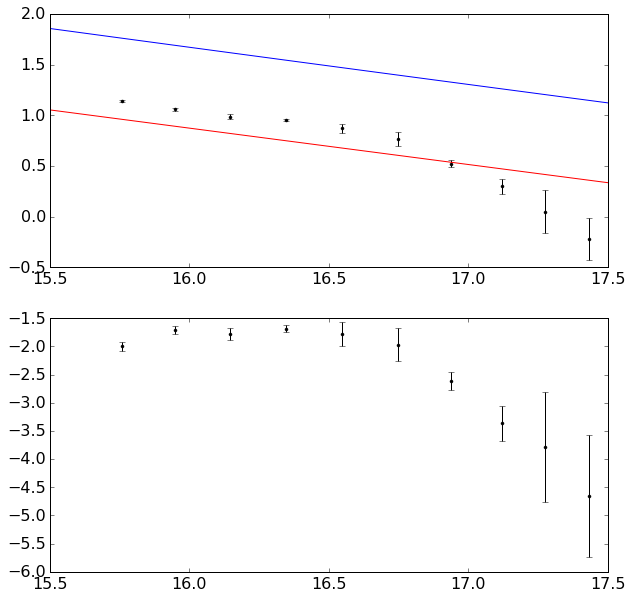

In [80]:
print(ener)
print(param[:, 0])
plt.subplot(211)

plt.errorbar(0.929*np.log10(all_vals.s)+6.06+9, all_vals.a, yerr= all_vals.aer1, fmt=".k")
#plt.plot(0.929*np.log10(all_vals.s)+6.06+9, np.ones(len(all_vals.s))*params_pr[0], color='r')
plt.plot(ener, param[:,0], color='r')
plt.plot(ener, param2[:,0], color='b')

#plt.plot(0.929*np.log10(all_vals.s)+6.06+9, np.ones(len(all_vals.s))*params_Fe[0], color='b')

plt.subplot(212)
plt.errorbar(0.929*np.log10(all_vals.s)+6.06+9, all_vals.b, yerr= all_vals.ber1, fmt=".k")
#plt.plot(ener, param[:,1], color='r')
#plt.plot(ener, param2[:,1], color='b')
#plt.plot(0.929*np.log10(all_vals.s)+6.06+9, np.ones(len(all_vals.s))*params_pr[1], color='r')
#plt.plot(0.929*np.log10(all_vals.s)+6.06+9, np.ones(len(all_vals.s))*params_Fe[1], color='b')




In [ ]:
import math
groups = fitted_data
sample = fit_results
cos_ref = np.cos(math.radians(25))**2
cos2 = np.linspace(0.5, 1, 20)-cos_ref

a_mcmc,  b_mcmc,  s38_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                  zip(*np.percentile(sample, [16, 50, 84],
                                      axis=0)))

#(mid_value, +error, -error)
print("a = %f + %f - %f\n"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
print("b = %f + %f - %f\n"%(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
print("s_ref = %f + %f - %f\n"%(s38_mcmc[0],s38_mcmc[1],s38_mcmc[2]))

# Plot a subset of the samples
plt.errorbar(groups.cos2.mean()-cos_ref, groups.s125.mean(), yerr= groups.s125.std().tolist(), fmt=".k")
for a, b, f in sample[np.random.randint(len(sample), size=250)]:
    plt.plot(cos2, f * (b * cos2**2 + a * cos2 + 1), color="b", alpha=0.03)
    plt.plot(cos2, s38_mcmc[0] * (b_mcmc[0] * cos2**2 + a_mcmc[0] * cos2 + 1), color="b", lw=0.5, alpha=0.8)
plt.errorbar(groups.cos2.mean()-cos_ref, groups.s125.mean(), yerr= groups.s125.std().tolist(), fmt=".k")

In [ ]:
import corner
fig = corner.corner(sample, labels=["$a$","$b$", "$s_{ref}$"], quantiles=[0.16, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 20}, color='b')
#fig.savefig("")
a_mcmc,  b_mcmc,  s38_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(sample, [16, 50, 84],
                                                axis=0)))

#(mid_value, +error, -error)
print("a = %f + %f - %f\n"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
print("b = %f + %f - %f\n"%(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
print("s38 = %f + %f - %f\n"%(s38_mcmc[0],s38_mcmc[1],s38_mcmc[2]))

In [ ]:
fig2, ax2 =plt.subplots(figsize=(10,6))
temp, groups = set_intensity(df, 8)
for name, group in groups:
    ax2.plot(np.log10(group.s125), group.I, 
             label='$theta$ = {}'.format(math.floor(math.degrees(group.zenith.mean()))))
ax2.set_yscale("log", nonposy='clip')
plt.xlabel("$log_{10}(S_{125}/VEM)$")
plt.ylabel("Intensity  [a.u.]")

plt.legend()


  

In [ ]:
np.log10(2*10**5)
    

In [ ]:
%run data_functions.py
from data_functions import set_intensity
df['s38'] = df.s125/(b_mcmc[0] * (df.cos2-cos_ref)**2 + a_mcmc[0] * (df.cos2-cos_ref) + 1)

print(df)
temp, groups = set_intensity(df, 4, 's38')
for name, group in groups:
    ax2.plot(np.log10(group.s125), group.I, 
             label='$theta$ = {}'.format(math.floor(math.degrees(group.zenith.mean()))))
ax2.set_yscale("log", nonposy='clip')
plt.xlabel("$log_{10}(S_{125}/VEM)$")
plt.ylabel("Intensity  [a.u.]")

plt.legend()